In [5]:
from pyspark.sql import SparkSession

# Create Spark session
spark = SparkSession.builder \
    .appName("EDA on CSV") \
    .getOrCreate()


# Importing Data

In [6]:
df = spark.read.csv("world_population.csv", header=True, inferSchema=True)

# Show schema (unchanged)
df.printSchema()

# Show formatted data (vertical + no truncation + more rows)
df.show(n=10, vertical=True, truncate=False)

root
 |-- Rank: integer (nullable = true)
 |-- CCA3: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Capital: string (nullable = true)
 |-- Continent: string (nullable = true)
 |-- 2022 Population: integer (nullable = true)
 |-- 2020 Population: integer (nullable = true)
 |-- 2015 Population: integer (nullable = true)
 |-- 2010 Population: integer (nullable = true)
 |-- 2000 Population: integer (nullable = true)
 |-- 1990 Population: integer (nullable = true)
 |-- 1980 Population: integer (nullable = true)
 |-- 1970 Population: integer (nullable = true)
 |-- Area (km²): integer (nullable = true)
 |-- Density (per km²): double (nullable = true)
 |-- Growth Rate: double (nullable = true)
 |-- World Population Percentage: double (nullable = true)

-RECORD 0------------------------------------------
 Rank                        | 36                  
 CCA3                        | AFG                 
 Country                     | Afghanistan         
 Capital        

# EDA 

## Data Dimensions

In [7]:

print(f"Rows: {df.count()}, Columns: {len(df.columns)}")

# Column names
print("Columns:", df.columns)


Rows: 234, Columns: 17
Columns: ['Rank', 'CCA3', 'Country', 'Capital', 'Continent', '2022 Population', '2020 Population', '2015 Population', '2010 Population', '2000 Population', '1990 Population', '1980 Population', '1970 Population', 'Area (km²)', 'Density (per km²)', 'Growth Rate', 'World Population Percentage']


## Data Types

In [8]:
df.dtypes

[('Rank', 'int'),
 ('CCA3', 'string'),
 ('Country', 'string'),
 ('Capital', 'string'),
 ('Continent', 'string'),
 ('2022 Population', 'int'),
 ('2020 Population', 'int'),
 ('2015 Population', 'int'),
 ('2010 Population', 'int'),
 ('2000 Population', 'int'),
 ('1990 Population', 'int'),
 ('1980 Population', 'int'),
 ('1970 Population', 'int'),
 ('Area (km²)', 'int'),
 ('Density (per km²)', 'double'),
 ('Growth Rate', 'double'),
 ('World Population Percentage', 'double')]

## Summary Statistics

In [9]:
numeric_cols = [col_name for col_name, data_type in df.dtypes if data_type in ("int", "bigint", "double", "float", "decimal")]

# Print the list of numeric columns
print("Numeric Columns:", numeric_cols)

# Compute summary statistics for numeric columns
if numeric_cols:
    df.select(*numeric_cols).summary().show(truncate=False)
else:
    print("No numeric columns found in the DataFrame.")


Numeric Columns: ['Rank', '2022 Population', '2020 Population', '2015 Population', '2010 Population', '2000 Population', '1990 Population', '1980 Population', '1970 Population', 'Area (km²)', 'Density (per km²)', 'Growth Rate', 'World Population Percentage']
+-------+----------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------+-----------------+--------------------+---------------------------+
|summary|Rank            |2022 Population     |2020 Population    |2015 Population     |2010 Population     |2000 Population     |1990 Population     |1980 Population     |1970 Population     |Area (km²)       |Density (per km²)|Growth Rate         |World Population Percentage|
+-------+----------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------

In [10]:
df.describe().show(vertical=True, truncate=False)

-RECORD 0-------------------------------------------
 summary                     | count                
 Rank                        | 234                  
 CCA3                        | 234                  
 Country                     | 234                  
 Capital                     | 234                  
 Continent                   | 234                  
 2022 Population             | 230                  
 2020 Population             | 233                  
 2015 Population             | 230                  
 2010 Population             | 227                  
 2000 Population             | 227                  
 1990 Population             | 229                  
 1980 Population             | 229                  
 1970 Population             | 230                  
 Area (km²)                  | 232                  
 Density (per km²)           | 230                  
 Growth Rate                 | 232                  
 World Population Percentage | 234            

## Null Values

In [11]:
from pyspark.sql.functions import col, isnan, when, count

# Count nulls and NaNs
df.select([count(when(col(c).isNull() | isnan(c), c)).alias(c) for c in df.columns]).show(vertical=True, truncate=False)


-RECORD 0--------------------------
 Rank                        | 0   
 CCA3                        | 0   
 Country                     | 0   
 Capital                     | 0   
 Continent                   | 0   
 2022 Population             | 4   
 2020 Population             | 1   
 2015 Population             | 4   
 2010 Population             | 7   
 2000 Population             | 7   
 1990 Population             | 5   
 1980 Population             | 5   
 1970 Population             | 4   
 Area (km²)                  | 2   
 Density (per km²)           | 4   
 Growth Rate                 | 2   
 World Population Percentage | 0   



## Histograms

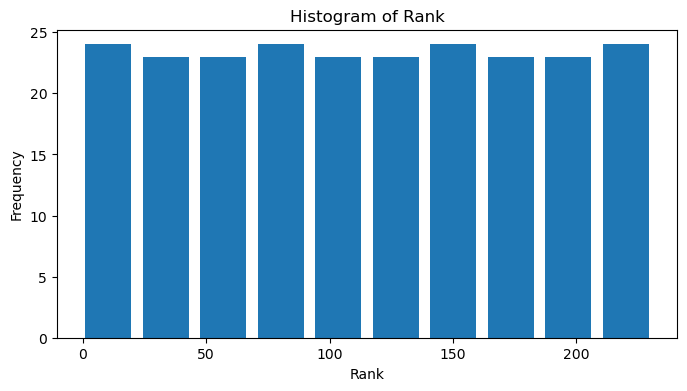

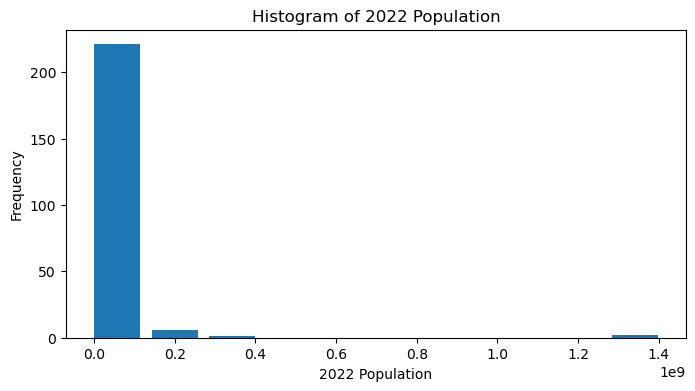

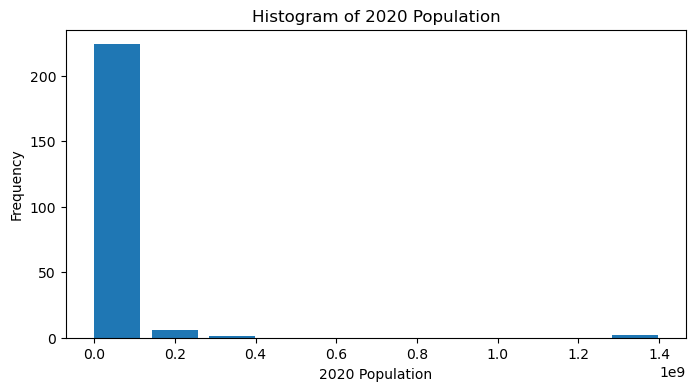

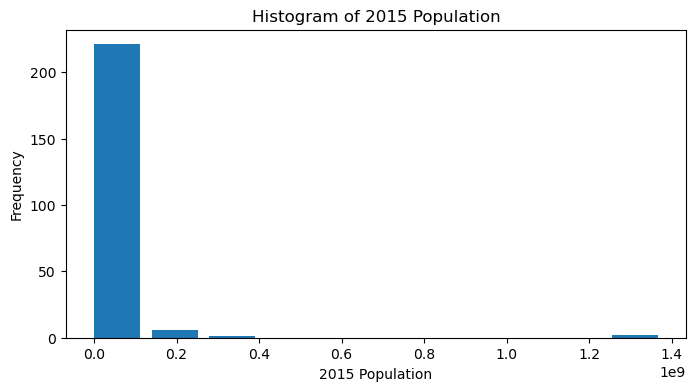

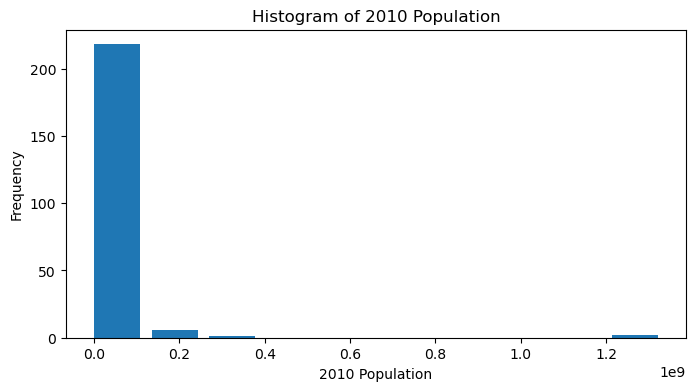

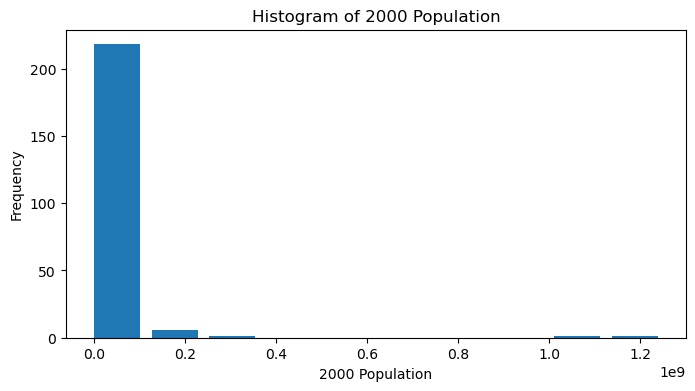

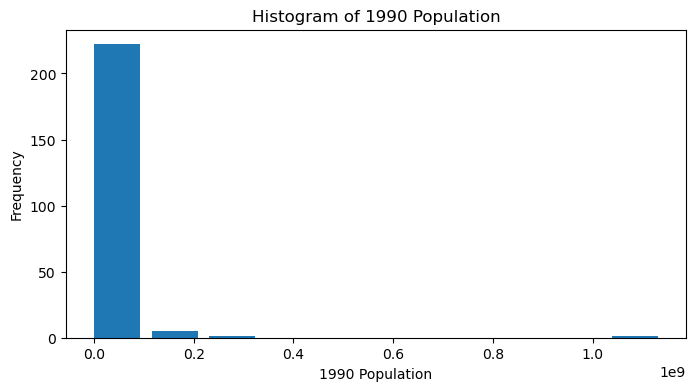

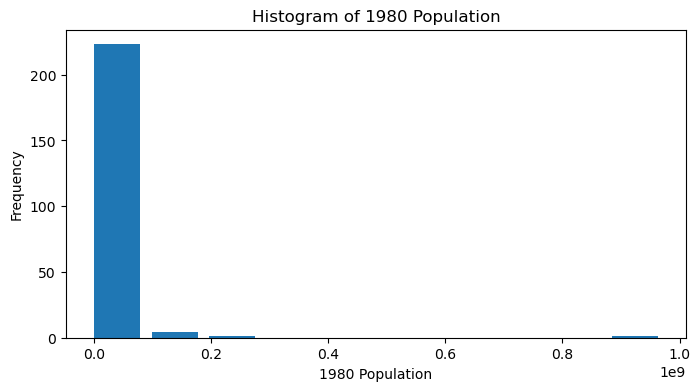

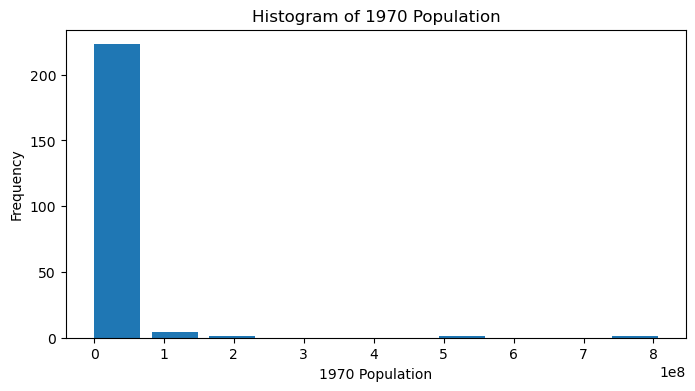

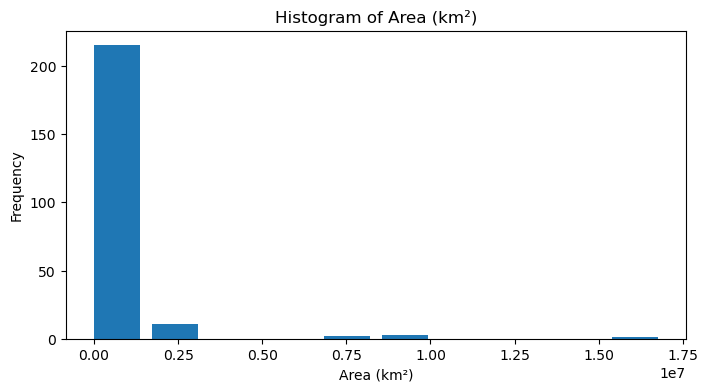

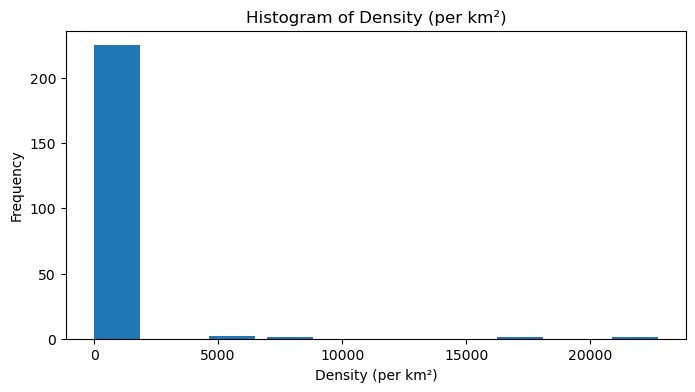

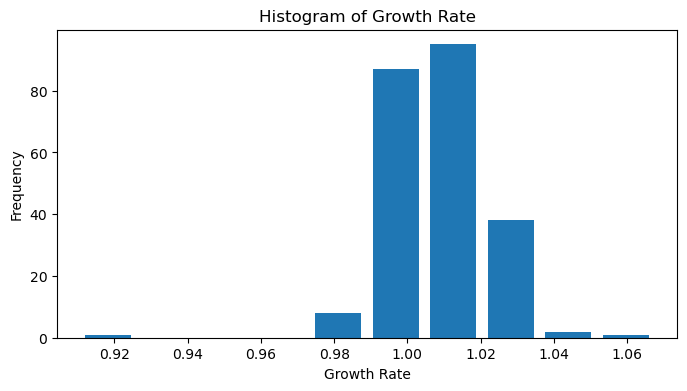

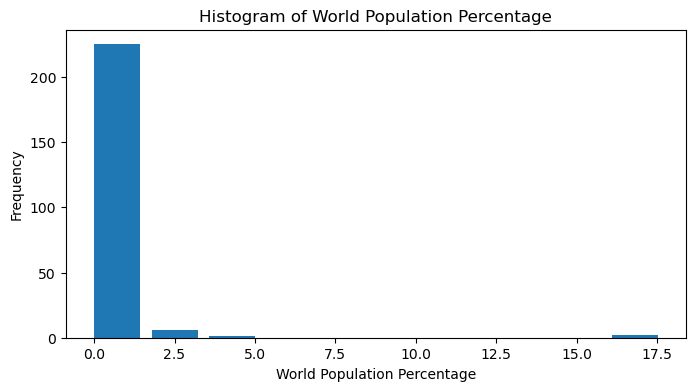

In [12]:
import matplotlib.pyplot as plt
for column in numeric_cols:
    
    bins, counts=df.select(column).rdd.flatMap(lambda x: x).histogram(10)    
    # Plot using matplotlib
    plt.figure(figsize=(8, 4))
    plt.bar(bins[:-1], counts, width=(bins[1] - bins[0]) * 0.8, align='edge')
    plt.title(f"Histogram of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.show()


# Preprocessing Starts

## Imputing Null Values

In [13]:
# Fill numeric nulls with mean
from pyspark.sql.functions import mean
for column in numeric_cols:
    mean_val = df.select(mean(column)).collect()[0][0]
    df = df.na.fill({column: mean_val})

# Fill categorical nulls with mode
nominal_cols= [column for column in df.columns if column not in numeric_cols]
for column in nominal_cols:
    mode = df.groupBy(column).count().orderBy("count", ascending=False).first()[0]
    df = df.na.fill({column: mode})


## Checking Nulls again

In [14]:
df.show()


+----+----+-------------------+----------------+-------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+----------+-----------------+-----------+---------------------------+
|Rank|CCA3|            Country|         Capital|    Continent|2022 Population|2020 Population|2015 Population|2010 Population|2000 Population|1990 Population|1980 Population|1970 Population|Area (km²)|Density (per km²)|Growth Rate|World Population Percentage|
+----+----+-------------------+----------------+-------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+----------+-----------------+-----------+---------------------------+
|  36| AFG|        Afghanistan|           Kabul|         Asia|       41128771|       38972230|       33753499|       28189672|       19542982|       10694796|       12486631|       10752971|    652230|          63.0587| 

In [15]:
from pyspark.sql.functions import col, isnan, when, count

# Count nulls and NaNs
df.select([count(when(col(c).isNull() | isnan(c), c)).alias(c) for c in df.columns]).show(vertical=True, truncate=False)


-RECORD 0--------------------------
 Rank                        | 0   
 CCA3                        | 0   
 Country                     | 0   
 Capital                     | 0   
 Continent                   | 0   
 2022 Population             | 0   
 2020 Population             | 0   
 2015 Population             | 0   
 2010 Population             | 0   
 2000 Population             | 0   
 1990 Population             | 0   
 1980 Population             | 0   
 1970 Population             | 0   
 Area (km²)                  | 0   
 Density (per km²)           | 0   
 Growth Rate                 | 0   
 World Population Percentage | 0   



## Dropping Duplicates

In [ ]:
df = df.dropDuplicates()


## Summary of Analysis

In [ ]:
* The World Population Dataset contains Population of different countries from years 1970 to 2022 with gaps(most of the columns are numeric hence)
* 

## SQL Starts

In [18]:

# Load CSV into DataFrame


# Create Temp View for SQL Queries
df.createOrReplaceTempView("world_population")


In [20]:


spark.sql("""
    select * from world_population
""").show()


+----+----+-------------------+----------------+-------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+----------+-----------------+-----------+---------------------------+
|Rank|CCA3|            Country|         Capital|    Continent|2022 Population|2020 Population|2015 Population|2010 Population|2000 Population|1990 Population|1980 Population|1970 Population|Area (km²)|Density (per km²)|Growth Rate|World Population Percentage|
+----+----+-------------------+----------------+-------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+----------+-----------------+-----------+---------------------------+
|  36| AFG|        Afghanistan|           Kabul|         Asia|       41128771|       38972230|       33753499|       28189672|       19542982|       10694796|       12486631|       10752971|    652230|          63.0587| 

In [27]:
pandas_df=spark.sql("""
    SELECT Continent, SUM(`1970 Population`) AS Total_Population_1970, SUM(`2022 Population`) AS Total_Population_2022
    FROM world_population
    GROUP BY Continent
    ORDER BY Total_Population_1970 DESC
""").toPandas()

In [28]:
pandas_df

,Continent,Total_Population_1970,Total_Population_2022
0,Asia,2136047134,4754674228
1,Europe,655923991,772345469
2,Africa,392927638,1460161512
3,North America,315434606,600296136
4,South America,192947156,436816608
5,Oceania,19480270,79652749


In [ ]:
pl